# ROC and precision-recall curves

Nuha BinTayyash, 2020

This notebook shows the ROC and precision-recall curves resulted from running GPcounts with one sample test on simulated bulk RNA-seq datasets.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn import metrics
import pandas as pd
from scipy import stats

In [2]:
from scipy import interpolate

def qvalue(pv, pi0=None):
    
    '''
    Estimates q-values from p-values
    This function is modified based on https://github.com/nfusi/qvalue

    GitHub - nfusi/qvalue: Converts p-values in q-values, see (Storey and Tibshirani, 2003)
    qvalue. Converts p-values in q-values, see (Storey and Tibshirani, 2003) The only function that needs to be called is 'estimate()'. It will accept a numpy array of pvalues and will return a numpy array of qvalues.
    github.com

    Args
    ====
    pi0: if None, it's estimated as suggested in Storey and Tibshirani, 2003.
    '''

    assert(pv.min() >= 0 and pv.max() <= 1), "p-values should be between 0 and 1"

    original_shape = pv.shape
    pv = pv.ravel()  # flattens the array in place, more efficient than flatten()

    m = float(len(pv))

    # if the number of hypotheses is small, just set pi0 to 1
    if len(pv) < 100 and pi0 is None:
        pi0 = 1.0
    elif pi0 is not None:
        pi0 = pi0
    else:
        # evaluate pi0 for different lambdas
        pi0 = []
        lam = np.arange(0, 0.90, 0.01)
        counts = np.array([(pv > i).sum() for i in np.arange(0, 0.9, 0.01)])
        for l in range(len(lam)):
            pi0.append(counts[l]/(m*(1-lam[l])))

        pi0 = np.array(pi0)

        # fit natural cubic spline
        tck = interpolate.splrep(lam, pi0, k=3)
        pi0 = interpolate.splev(lam[-1], tck)

        if pi0 > 1:
            pi0 = 1.0

    assert(pi0 >= 0 and pi0 <= 1), "pi0 is not between 0 and 1: %f" % pi0

    p_ordered = np.argsort(pv)
    pv = pv[p_ordered]
    qv = pi0 * m/len(pv) * pv
    qv[-1] = min(qv[-1], 1.0)

    for i in range(len(pv)-2, -1, -1):
        qv[i] = min(pi0*m*pv[i]/(i+1.0), qv[i+1])

    # reorder qvalues
    qv_temp = qv.copy()
    qv = np.zeros_like(qv)
    qv[p_ordered] = qv_temp

    # reshape qvalues
    qv = qv.reshape(original_shape)

    return qv


low_counts_low_dispersion_non_differentially_expressed_genes_DE_non_DE_genes.csv


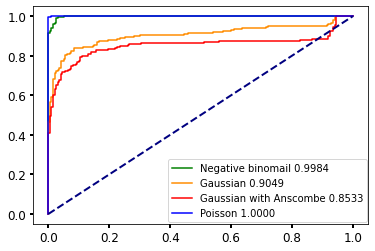

Number of differentially expressed genes: 200.0
GPcounts with Negative Binomial likelihood
AUC: 0.998375
the numbers of genes less than 0.05 : 60
kstest for non DE genes: KstestResult(statistic=1.0, pvalue=0.0)


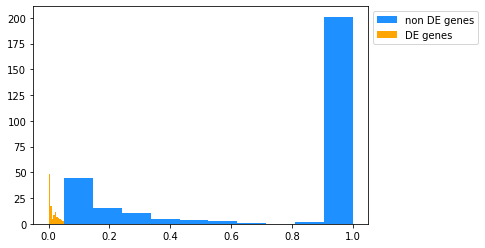

GPcounts with Gaussian likelihood
AUC: 0.904925
the numbers of genes greater than 0.05 : 54
kstest for non DE genes: KstestResult(statistic=1.0, pvalue=0.0)


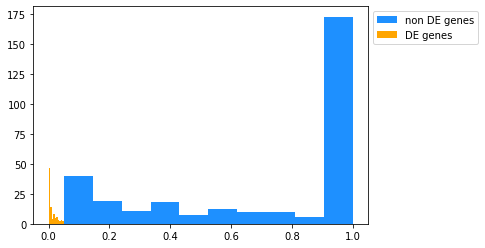

GPcounts with Gaussian Anscombe likelihood
AUC: 0.853325
the numbers of genes greater than 0.05 : 19
kstest for non DE genes: KstestResult(statistic=1.0, pvalue=0.0)


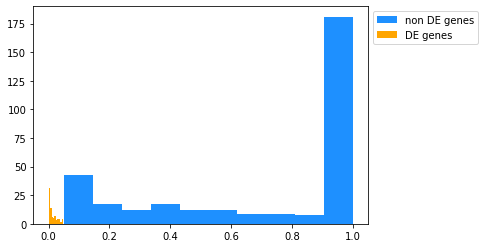

GPcounts with Poisson likelihood
AUC: 0.99995
the numbers of genes less than 0.05 : 199
kstest for non DE genes: KstestResult(statistic=1.0, pvalue=0.0)
200


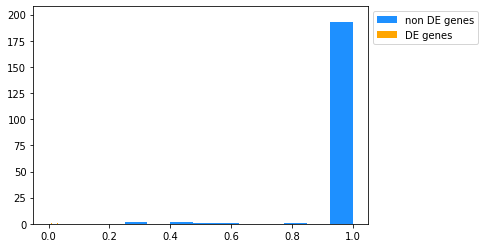

In [3]:
filesname = [
             'low_counts_low_dispersion_non_differentially_expressed_genes_DE_non_DE_genes.csv'
            #,'low_counts_high_dispersion_non_differentially_expressed_genes_DE_non_DE_genes.csv'                                     
            #,'high_counts_low_dispersion_non_differentially_expressed_genes_DE_non_DE_genes.csv'
            #,'high_counts_high_dispersion_non_differentially_expressed_genes_DE_non_DE_genes.csv'
            ]
            
for file in filesname:
    print(file)
    
    Gaussian = pd.read_csv('ll_ratio_Gaussian_'+file,index_col=[0])
    Gaussian_anscombe = pd.read_csv('ll_ratio_Gaussian_Anscombe_transformation_'+file,index_col=[0])
    NegativeBinomial = pd.read_csv('ll_ratio_Negative_binomial_'+file,index_col=[0])
    Poisson = pd.read_csv('ll_ratio_Poisson_'+file,index_col=[0])
    
    D = NegativeBinomial.shape[0]
    true_label = np.zeros(D)
    
    for j in range(D):
        if j %2 == 0:
            true_label[j] = 1

    labels = pd.DataFrame(true_label, index =NegativeBinomial.index.values, columns =['label'])
    NegativeBinomial = pd.concat([NegativeBinomial,labels],axis = 1)

    fig = plt.figure()
    
    plt.tick_params(labelsize='large', width=2)     
    fpr_NB, tpr_NB, thresholds_NB = metrics.roc_curve( NegativeBinomial['label'], NegativeBinomial['log_likelihood_ratio'])
    AUC_NB=metrics.auc(fpr_NB, tpr_NB)
    plt.plot(fpr_NB, tpr_NB,color='green',label='Negative binomail {0:.4f}'.format(AUC_NB))
    
    
    fpr_G, tpr_G, thresholds_G = metrics.roc_curve(NegativeBinomial['label'],Gaussian['log_likelihood_ratio'])
    AUC_G=metrics.auc(fpr_G, tpr_G)
    plt.plot(fpr_G, tpr_G, color='darkorange', label='Gaussian {0:.4f}'.format(AUC_G))
    
    fpr_G_a, tpr_G_a, thresholds_G_a = metrics.roc_curve(NegativeBinomial['label'],Gaussian_anscombe['log_likelihood_ratio'])
    AUC_G_a=metrics.auc(fpr_G_a, tpr_G_a)
    plt.plot(fpr_G_a, tpr_G_a, color='red', label='Gaussian with Anscombe {0:.4f}'.format(AUC_G_a))
    
    fpr_P, tpr_P, thresholds_P = metrics.roc_curve( NegativeBinomial['label'], Poisson['log_likelihood_ratio'])
    AUC_P=metrics.auc(fpr_P, tpr_P)
    plt.plot(fpr_P, tpr_P,color='blue',label='Poisson {0:.4f}'.format(AUC_P))

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    
    plt.legend(loc='upper center', bbox_to_anchor=(.70, 0.32))
    plt.show()
    print('Number of differentially expressed genes:',D/2)
    
    
    pval_NB = 1 - stats.chi2.cdf(NegativeBinomial['log_likelihood_ratio'], df=1)
    pval_NB.reshape(-1)[2]
    pval_NB = pd.DataFrame(pval_NB)
    #pval_non_DE_NB = pval_NB.iloc[list(range(1, pval_NB.shape[0], 2)),:]
    #pval_DE_NB = pval_NB.iloc[list(range(0, pval_NB.shape[0], 2)),:]
    DE_pval_NB = list(pval_NB.loc[(pval_NB[0] < 0.05)].index.values)
    non_DE_pval_NB = list(pval_NB.loc[(pval_NB[0] >= 0.05)].index.values)
    qvals_NB = []
    #pval_NB=pval_NB['2']
    qvals_NB = qvalue(pval_NB.values)
    count_NB = 0
    
    for i in qvals_NB :
        if i < 0.05 :
            count_NB = count_NB + 1
    
    print("GPcounts with Negative Binomial likelihood")        
    print('AUC:',AUC_NB)       
    print ("the numbers of genes less than 0.05 : " + str(count_NB))    
    print("kstest for non DE genes:",stats.kstest(pval_NB.iloc[non_DE_pval_NB,:].values, 'uniform', args=(0,1)))
    plt.hist(pval_NB.iloc[non_DE_pval_NB,:].values.ravel(),color="dodgerblue", label="non DE genes", bins=10)
    plt.legend(bbox_to_anchor=(1, 1))
    #plt.show()
    plt.hist(pval_NB.iloc[DE_pval_NB,:].values.ravel(),color="orange", label="DE genes", bins=10)
    plt.legend(bbox_to_anchor=(1, 1))
    plt.show()

    pval_G = 1 - stats.chi2.cdf(Gaussian['log_likelihood_ratio'], df=1)
    pval_G.reshape(-1)[2]
    pval_G = pd.DataFrame(pval_G)
    DE_pval_G = list(pval_G.loc[(pval_G[0] < 0.05)].index.values)
    non_DE_pval_G = list(pval_G.loc[(pval_G[0] >= 0.05)].index.values)
    qvals_G = []
    #pval=pval['2']
    qvals_G = qvalue(pval_G.values)
    count_G = 0
    for i in qvals_G :
        if i < 0.05 :
            count_G = count_G + 1

    print("GPcounts with Gaussian likelihood")        
    print('AUC:',AUC_G)       
    print ("the numbers of genes greater than 0.05 : " + str(count_G))
    print("kstest for non DE genes:",stats.kstest(pval_G.iloc[non_DE_pval_G,:].values, 'uniform', args=(0, 1)))
    plt.hist(pval_G.iloc[non_DE_pval_G,:].values.ravel(),color="dodgerblue", label="non DE genes", bins=10)
    #plt.show()
    plt.legend(bbox_to_anchor=(1, 1))
    plt.hist(pval_G.iloc[DE_pval_G,:].values.ravel(),color="orange", label="DE genes", bins=10)
    plt.legend(bbox_to_anchor=(1, 1))
    plt.show()
    
    pval_G_a = 1 - stats.chi2.cdf(Gaussian_anscombe['log_likelihood_ratio'], df=1)
    pval_G_a.reshape(-1)[2]
    pval_G_a = pd.DataFrame(pval_G_a)
    DE_pval_G_a = list(pval_G_a.loc[(pval_G_a[0] < 0.05)].index.values)
    non_DE_pval_G_a = list(pval_G_a.loc[(pval_G_a[0] >= 0.05)].index.values)
    qvals_G_a = []
    #pval=pval['2']
    qvals_G_a = qvalue(pval_G_a.values)
    count_G_a = 0
    for i in qvals_G_a :
        if i < 0.05 :
            count_G_a = count_G_a + 1

    print("GPcounts with Gaussian Anscombe likelihood")        
    print('AUC:',AUC_G_a)       
    print ("the numbers of genes greater than 0.05 : " + str(count_G_a))
    print("kstest for non DE genes:",stats.kstest(pval_G_a.iloc[non_DE_pval_G_a,:].values, 'uniform', args=(0, 1)))
    plt.hist(pval_G_a.iloc[non_DE_pval_G_a,:].values.ravel(),color="dodgerblue", label="non DE genes", bins=10)
    #plt.show()
    plt.legend(bbox_to_anchor=(1, 1))
    plt.hist(pval_G_a.iloc[DE_pval_G_a,:].values.ravel(),color="orange", label="DE genes", bins=10)
    plt.legend(bbox_to_anchor=(1, 1))
    plt.show()
 
    
    pval_P = 1 - stats.chi2.cdf(Poisson['log_likelihood_ratio'], df=1)
    pval_P.reshape(-1)[2]
    pval_P = pd.DataFrame(pval_P)
    #pval_non_DE_P = pval_P.iloc[list(range(1, pval_P.shape[0], 2)),:]
    #pval_DE_P = pval_P.iloc[list(range(0, pval_P.shape[0], 2)),:]
    DE_pval_P = list(pval_P.loc[(pval_P[0] < 0.05)].index.values)
    non_DE_pval_P = list(pval_P.loc[(pval_P[0] >= 0.05)].index.values)
    qvals_P = []
    #pval_P=pval_P['2']
    qvals_P = qvalue(pval_P.values)
    count_P = 0
    
    for i in qvals_P :
        if i < 0.05 :
            count_P = count_P + 1
    
    print("GPcounts with Poisson likelihood")        
    print('AUC:',AUC_P)       
    print ("the numbers of genes less than 0.05 : " + str(count_P))    
    print("kstest for non DE genes:",stats.kstest(pval_P.iloc[non_DE_pval_P,:].values, 'uniform', args=(0,1)))
    plt.hist(pval_P.iloc[non_DE_pval_P,:].values.ravel(),color="dodgerblue", label="non DE genes", bins=10)
    plt.legend(bbox_to_anchor=(1, 1))
    print(len(pval_P.iloc[non_DE_pval_P,:].values.ravel()))
    #plt.show()
    plt.hist(pval_P.iloc[DE_pval_P,:].values.ravel(),color="orange", label="DE genes", bins=10)
    plt.legend(bbox_to_anchor=(1, 1))
    plt.show